## Introduction

This jupyter notebook show the process of how we obtain the feature map and visualization of different sampling methods, in our experiment.

It is not runnalbe due to lack of data (about 10 GB). If you are interested in the data, please access "https://github.com/497662892/Ai-Security-Final-Project"

For simplicity, we implement the sampling strategy assuming we already have the feature map, in the implementation.ipynb.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
os.chdir('/home/user01/majiajian/code/segmentation/Polyp-PVT')

import shutil
import sys
from lib.pvt import PolypPVT
import torch
import cv2
import PIL.Image as Image
import torchvision.transforms as transforms
import torch.nn.functional as F


/home/user01/software/miniconda3/envs/diffuser/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# organize the data
data_csv = "/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv"
data_csv = pd.read_csv(data_csv)

images_path = data_csv['original_image'].tolist()
image_labels = [1] * len(images_path)

inpaint_images_path = data_csv['inpaint_image'].tolist()
inpaint_labels = [0] * len(inpaint_images_path)

images = images_path + inpaint_images_path
labels = image_labels + inpaint_labels

testsize = 352
image_transform = transforms.Compose([
            transforms.Resize((testsize, testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])

In [6]:
# set the visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# load the model to extra feature

def load_model(baseline_path = "/home/user01/majiajian/code/segmentation/Polyp-PVT/model_pth/SUN-SEG_baseline_2024-04-30-16-13-35/14PolypPVT-best.pth"):
    model = PolypPVT()
    model.load_state_dict(torch.load(baseline_path))
    model.cuda()
    model.eval()
    return model

# model = load_model()


PolypPVT(
  (backbone): pvt_v2_b2(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_feature

In [7]:
# get the feature map of each images, save it to the feature_map folder

def get_feature_map(model= load_model(), output_dir = "/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps"):
    os.makedirs(output_dir, exist_ok=True)
    output_dir_1 = os.path.join(output_dir, '1')
    output_dir_0 = os.path.join(output_dir, '0')
    os.makedirs(output_dir_1, exist_ok=True)
    os.makedirs(output_dir_0, exist_ok=True)

    for i in range(len(images)):
        image = Image.open(images[i]).convert('RGB')
        image = image_transform(image).unsqueeze(0).cuda()
        feature_map = model.backbone(image)[-1] # take the last layer feature map
        gap_features = F.adaptive_avg_pool2d(feature_map, (1, 1)).view(feature_map.size(0), -1)
        # turn into numpy and save into the folder
        gap_features = gap_features.cpu().detach().squeeze(0).numpy()
        if labels[i] == 1:
            np.save(os.path.join(output_dir_1, os.path.basename(images[i]).replace('.jpg', '.npy')), gap_features)
        else:
            np.save(os.path.join(output_dir_0, os.path.basename(images[i]).replace('.jpg', '.npy')), gap_features)

# get_feature_map()

In [11]:
# visualize the feature map with t-SNE
from sklearn.manifold import TSNE
import seaborn as sns


def visualize_distribution(feature_map_dir="/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps", 
                           name_list = None,
                           output_name = 'feature_map_tsne.png'):

    feature_map_dir_1 = os.path.join(feature_map_dir, '1')
    feature_map_dir_0 = os.path.join(feature_map_dir, '0')

    feature_map_files_1 = os.listdir(feature_map_dir_1)
    feature_map_files_0 = os.listdir(feature_map_dir_0)

    feature_map_original = []
    feature_map_synthetic = []
    feature_map_selected = []

    for file in feature_map_files_1:
        feature_map_original.append(np.load(os.path.join(feature_map_dir_1, file)))
    for file in feature_map_files_0:
        if name_list is None:
            feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_0, file)))
        else:
            if file.split(".")[0] in name_list:
                feature_map_selected.append(np.load(os.path.join(feature_map_dir_0, file)))
            else:
                feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_0, file)))

    feature_map_original = np.array(feature_map_original)
    feature_map_synthetic = np.array(feature_map_synthetic)
    feature_map_selected = np.array(feature_map_selected)

    if len(feature_map_selected) == 0:
        feature_map = np.concatenate([feature_map_original, feature_map_synthetic], axis=0)
        labels = ["original"] * len(feature_map_original) + ["synthetic"] * len(feature_map_synthetic)
    else:
        feature_map = np.concatenate([feature_map_original, feature_map_synthetic, feature_map_selected], axis=0)
        labels = ["original"] * len(feature_map_original) + ["synthetic"] * len(feature_map_synthetic) + ["selected"] * len(feature_map_selected)

    tsne = TSNE(n_components=2, random_state=0)
    feature_map_tsne = tsne.fit_transform(feature_map)

    feature_map_tsne = pd.DataFrame(feature_map_tsne, columns=['x', 'y'])
    feature_map_tsne['label'] = labels

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='x', y='y', hue='label', data=feature_map_tsne)
    plt.savefig(os.path.join(feature_map_dir, output_name))
    plt.show()


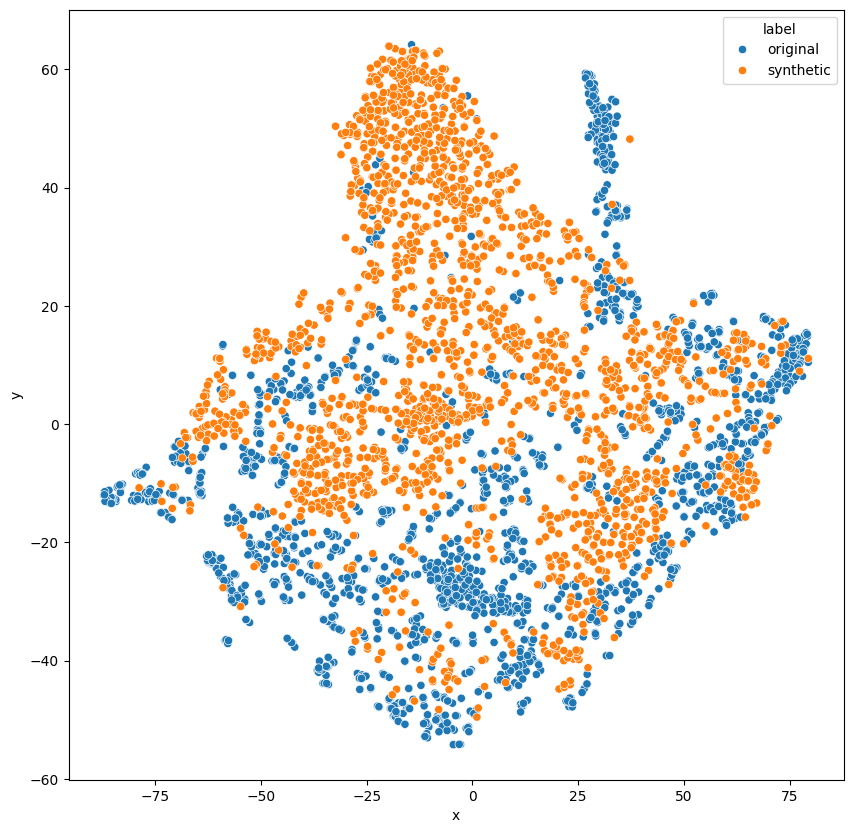

In [12]:
visualize_distribution()

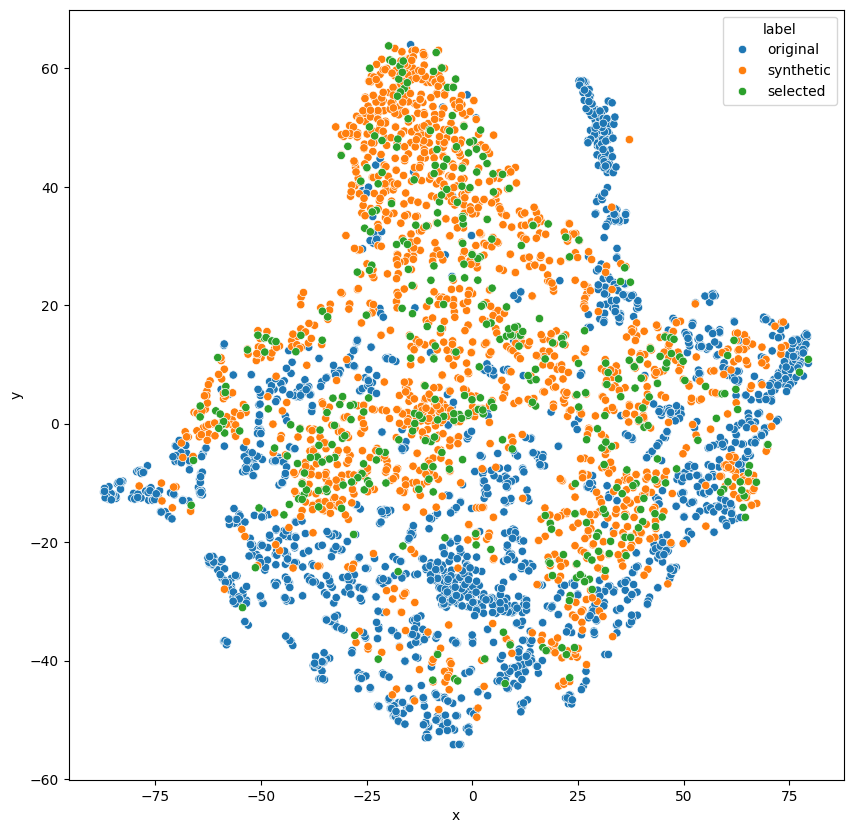

In [13]:
# update label with random selection
data_csv = "/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv"
max_num = 400

data_csv = pd.read_csv(data_csv)
filter_data = data_csv[data_csv['alignment_score'] > 0.8]
sample_data = filter_data.sample(n=max_num, random_state=0)
names = sample_data['name'].tolist()

visualize_distribution(name_list=names, output_name='feature_map_tsne_random.png')

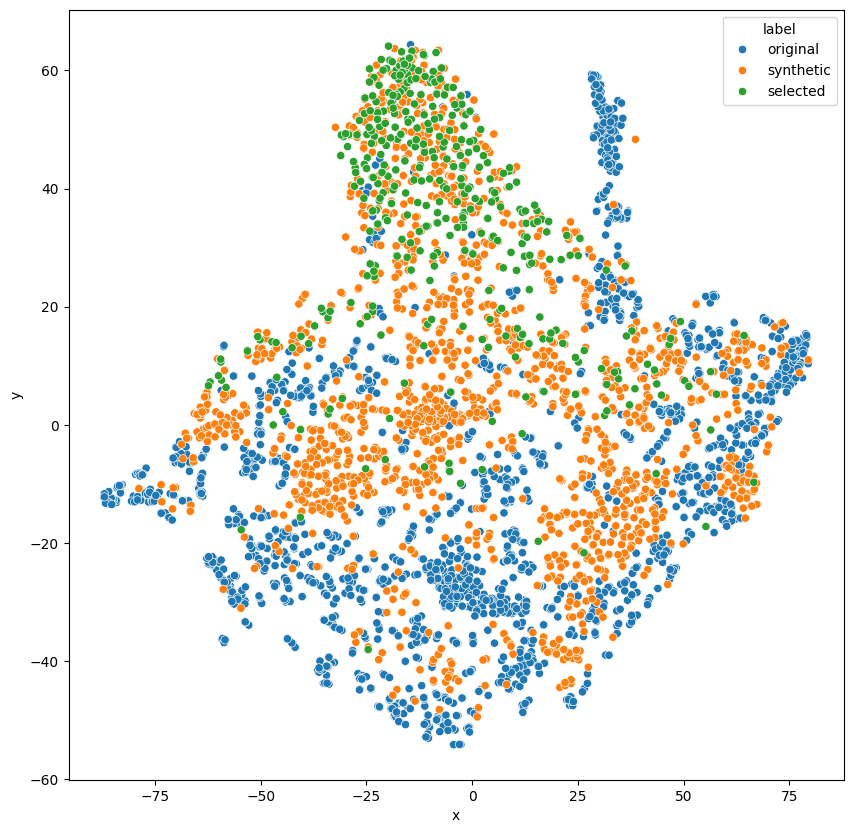

In [14]:
# update label with worst prediction selection
data_csv = "/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv"
max_num = 400

data_csv = pd.read_csv(data_csv)
filter_data = data_csv[data_csv['alignment_score'] > 0.8]
sample_data = filter_data.sort_values(by='prediction_score', ascending=True).head(max_num)
names = sample_data['name'].tolist()

visualize_distribution(name_list=names, output_name='feature_map_tsne_prediction.png')

In [21]:
def euclidean_distance_matrix(X, Y):
    """计算两组点之间的欧氏距离矩阵。"""
    D = np.sqrt(((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2).sum(axis=2))
    return D

def load_feature_map(feature_map_dir, name_list=None):
    # load the feature map
    feature_map_dir_1 = os.path.join(feature_map_dir, '1')
    feature_map_dir_0 = os.path.join(feature_map_dir, '0')

    feature_map_files_1 = os.listdir(feature_map_dir_1)
    feature_map_files_0 = os.listdir(feature_map_dir_0)

    feature_map_original = []
    feature_map_synthetic = []

    # only load the selected synthetic data (the qualified synthetic data)
    for file in feature_map_files_1:
        feature_map_original.append(np.load(os.path.join(feature_map_dir_1, file)))
    for file in feature_map_files_0:
        if name_list is None:
            raise ValueError("name_list of align cases should not be None")
        else:
            if file.split(".")[0] in name_list:
                feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_0, file)))
    
    feature_map_original = np.array(feature_map_original)
    feature_map_synthetic = np.array(feature_map_synthetic)
    
    return feature_map_original, feature_map_synthetic

def save_data_distance_matrix(feature_map_original, feature_map_synthetic, output_dir):
    # calculate the distance matrix
    dist_to_real = euclidean_distance_matrix(feature_map_synthetic, feature_map_original)
    dist_to_synthetic = euclidean_distance_matrix(feature_map_synthetic, feature_map_synthetic)
    # save the distance matrix
    np.save(os.path.join(output_dir, 'dist_to_real.npy'), dist_to_real)
    np.save(os.path.join(output_dir, 'dist_to_synthetic.npy'), dist_to_synthetic)
    

def select_synthetic_data(data, synthetic_data, dist_to_real_path, dist_to_synthetic_path, name_list, num_samples):
    n_synthetic = synthetic_data.shape[0]
    n_data = data.shape[0]

    # 预计算距离矩阵
    dist_to_real = np.load(dist_to_real_path)
    dist_to_synthetic = np.load(dist_to_synthetic_path)

    # take the point with maximun distance to the real data as initial point
    initial_index = np.argmax(dist_to_real.mean(axis=1))
    selected_indices = [initial_index]
    
    while len(selected_indices) < num_samples:
        remaining_indices = list(set(range(n_synthetic)) - set(selected_indices))
        
        # 计算到真实样本的平均距离和到已选合成样本的平均距离
        avg_dist_to_real = dist_to_real[remaining_indices, :].mean(axis=1)
        avg_dist_to_selected = dist_to_synthetic[np.ix_(remaining_indices, selected_indices)].mean(axis=1)
        
        # 选择平均距离之和最大的点
        sum_distances = avg_dist_to_real + avg_dist_to_selected
        next_index = remaining_indices[np.argmax(sum_distances)]
        selected_indices.append(next_index)

    return selected_indices, [name_list[i] for i in selected_indices]

In [24]:
data_csv = "/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv"
data_csv = pd.read_csv(data_csv)
# all synthetic data should be include
names = data_csv['name'].tolist()

feature_map_original, feature_map_synthetic = load_feature_map("/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps", name_list=names)
save_data_distance_matrix(feature_map_original, feature_map_synthetic, "/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps")

In [26]:
dist_to_real_path = "/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps/dist_to_real.npy"
dist_to_synthetic_path = "/home/user01/majiajian/data/polyp/SUN-SEG_10/feature_maps/dist_to_synthetic.npy"

# all synthetic data should be include, the order of selection is essential!
selected_indices, name_in_order = select_synthetic_data(feature_map_original, feature_map_synthetic, dist_to_real_path, dist_to_synthetic_path, name_list=names, num_samples=len(names))
print(len(name_in_order))

1993


In [27]:
# update the label of distance selection
data_csv = "/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv"
data_csv = pd.read_csv(data_csv)
for i in range(len(name_in_order)):
    data_csv.loc[data_csv['name'] == name_in_order[i], 'priority'] = i
data_csv.to_csv("/home/user01/majiajian/data/polyp/SUN-SEG_10/match_data/1_data.csv", index=False)

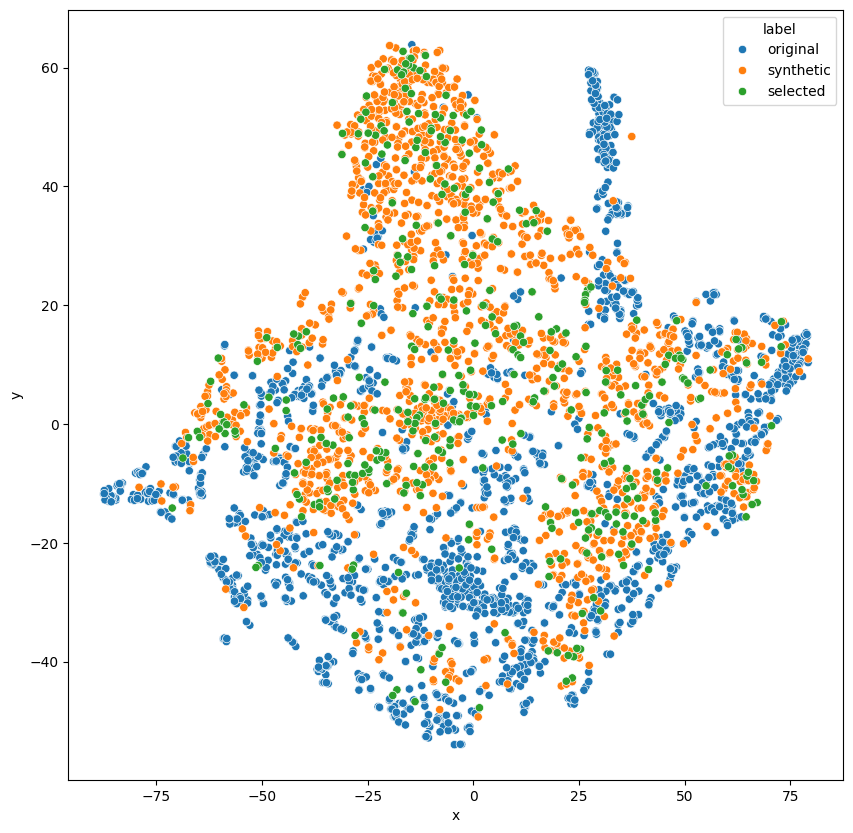

In [28]:
filter_data = data_csv[data_csv['alignment_score'] > 0.8]
sample_data = filter_data.sort_values(by='priority', ascending=True).head(400)
names = sample_data['name'].tolist()
visualize_distribution(name_list=names, output_name='feature_map_tsne_distance.png')